<a href="https://colab.research.google.com/github/100495699/Aprendizaje/blob/main/Aprendizaje.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA simplificado

En esta seccion vamos a cargar y analizar el dataset para entender mejor su estructura. Identificaremos los diferentes campos, sus valores, valores faltantes, rangos y una matriz de dependencia. Además seleccionaremos los campos más importantes para el modelo de predicción de abandonos.

Primero, importaremos todas las librerias necesarios. *Pandas* para leer el dataset, *sklearn* para el desarrollo de los modelos y *numpy* junto con *mathplotlib* para funciones adicionales.

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, recall_score, confusion_matrix)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn import neighbors
!pip install statsmodels

El primer paso será cargar el dataset con *pandas* y mostrar el numero de filas, columnas y el nombre de todas las columnas

In [33]:
dataset = pd.read_csv('attrition_availabledata_05.csv')
num_filas, num_columnas = dataset.shape

# Estructura del dataset
print(f"Número de filas: {num_filas}")
print(f"Número de columnas: {num_columnas}")
# Ver nombres de todas las columnas
print("Nombres de las columnas:")
print(dataset.columns.tolist())



Número de filas: 2940
Número de columnas: 31
Nombres de las columnas:
['hrs', 'absences', 'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age', 'BusinessTravel', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount', 'EmployeeID', 'Gender', 'JobLevel', 'JobRole', 'MaritalStatus', 'MonthlyIncome', 'NumCompaniesWorked', 'Over18', 'PercentSalaryHike', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'Attrition']


A continuación vemos los diferentes valores únicos que toman los diferentes registros para cada columna. De esta forma será más fácil ver el tipo de las variables (categóricas, ordinales o numéricas)

In [34]:
for col in dataset.columns:
    valores_unicos = dataset[col].unique()
    print(f"Valores '{col}':{valores_unicos}")

Valores 'hrs':[6.61262494 6.02681504 6.96645582 ... 6.59509148 7.38075747 6.45303882]
Valores 'absences':[18 11 12 10 14 15  2 17 23 22  8  4  5  9  6 21  3  7 19 16 20 13 24  1]
Valores 'JobInvolvement':[4 3 2 1]
Valores 'PerformanceRating':[3 4]
Valores 'EnvironmentSatisfaction':[ 3.  4.  2.  1. nan]
Valores 'JobSatisfaction':[ 3.  4.  1.  2. nan]
Valores 'WorkLifeBalance':[ 2.  3.  1.  4. nan]
Valores 'Age':[31 33 48 42 34 53 50 39 37 45 36 30 40 41 27 43 38 24 18 51 32 47 26 46
 44 29 60 22 35 28 59 57 58 55 20 25 54 19 49 52 56 23 21]
Valores 'BusinessTravel':['Travel_Frequently' 'Travel_Rarely' 'Non-Travel']
Valores 'Department':['Sales' 'Human Resources' 'Research & Development']
Valores 'DistanceFromHome':[10  3  8 11  9  5  6  2  1 28 29 23 19 21 14 25  4  7 16 24 12 26 18 15
 22 17 27 20 13]
Valores 'Education':[3 1 4 2 5]
Valores 'EducationField':['Technical Degree' 'Marketing' 'Medical' 'Life Sciences' 'Other'
 'Human Resources']
Valores 'EmployeeCount':[1]
Valores 'Employe

Una vez tenemos los valores únicos que pueden tomar las variables se observa que:

*   **Variables numericas:** hrs, absences, Age, DistanceFromHome, MonthlyIncome, NumCompaniesWorked, PercentSalaryHike, TotalWorkingYears, YearsAtCompany, YearsSinceLastPromotion, YearsWithCurrManager

*   **Variables categóricas:** BusinessTravel, Department, EducationField, Gender, JobRole, MaritalStatus, Attrition

*   **Variables ordinales:** JobInvolvement, PerformanceRating, EnvironmentSatisfaction, JobSatisfaction, WorkLifeBalance, Education, JobLevel, StockOptionLevel, TrainingTimesLastYear

Además, localizamos una serie de variables que toman valores constantes o son ids y, por tanto no aportan información adicional y podrian eliminarse.

* **Variables especiales:** EmployeeCount, EmployeeID, Over18, StandardHours



Si ahora nos centramos en las variables numéricas, hay que tener en cuenta las variables con muchos valores faltantes o valores no validos. Para controlar esto, vamos a ver la cantidad de valores no validos o faltantes para las variables de dicha categoría.


In [35]:
columnas_numericas= ["hrs", "absences", "Age", "DistanceFromHome", "MonthlyIncome", "NumCompaniesWorked",
 "PercentSalaryHike", "TotalWorkingYears", "YearsAtCompany", "YearsSinceLastPromotion", "YearsWithCurrManager"]

print(dataset[columnas_numericas].isnull().sum())

hrs                         0
absences                    0
Age                         0
DistanceFromHome            0
MonthlyIncome               0
NumCompaniesWorked         13
PercentSalaryHike           0
TotalWorkingYears           6
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
dtype: int64


Observamos que en la columna NumCompaniesWorked hay 13 registros que no tienen valor, [DECIDIR QUÉ HACER]

Para las cariables categóricas, es importante saber factores como la cardinalidad, los valores faltantes y, si es necesario, la codificacion de variables para transformarlas a numericas.

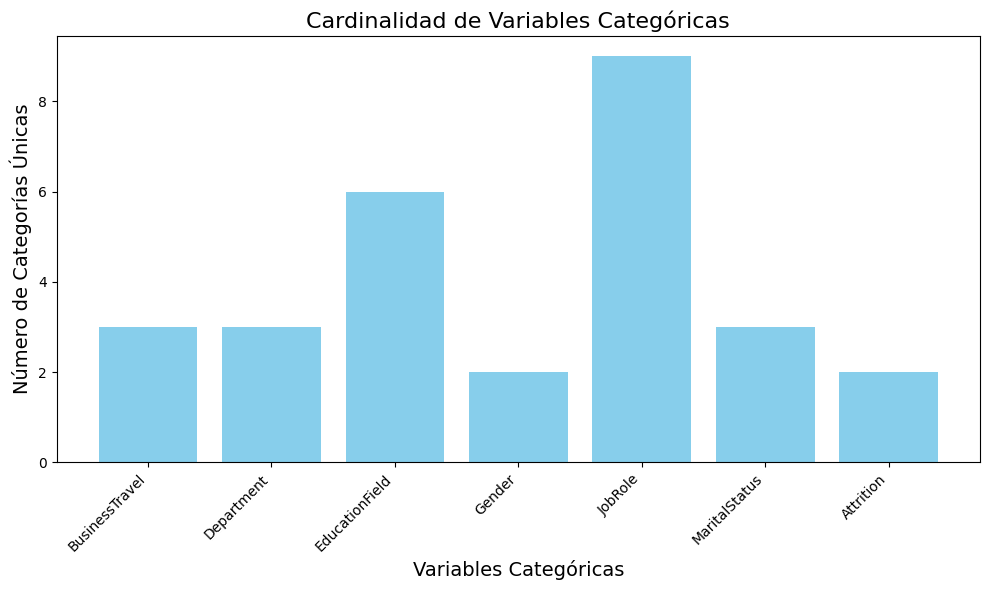

In [36]:
columnas_categoricas = ["BusinessTravel", "Department", "EducationField", "Gender", "JobRole", "MaritalStatus", "Attrition"]
card = dataset[columnas_categoricas].nunique()

# Crear un gráfico de barras para mostrar la cardinalidad
plt.figure(figsize=(10, 6))
plt.bar(card.index, card.values, color='skyblue')
plt.title("Cardinalidad de Variables Categóricas", fontsize=16)
plt.xlabel("Variables Categóricas", fontsize=14)
plt.ylabel("Número de Categorías Únicas", fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas del eje x para mejor legibilidad

# Mostrar el gráfico
plt.tight_layout()  # Ajustar el layout para que no se corten las etiquetas
plt.show()

Hacemos lo mismo para las variables ordinales


In [37]:
columnas_ordinales = ["JobInvolvement", "PerformanceRating", "EnvironmentSatisfaction", "JobSatisfaction", "WorkLifeBalance", "Education", "JobLevel", "StockOptionLevel", "TrainingTimesLastYear"]
print(dataset[columnas_ordinales].isnull().sum())

JobInvolvement              0
PerformanceRating           0
EnvironmentSatisfaction    16
JobSatisfaction            17
WorkLifeBalance            20
Education                   0
JobLevel                    0
StockOptionLevel            0
TrainingTimesLastYear       0
dtype: int64


Para determinar el tipo de problema que se plantea, se observa la variable objetivo 'attrition'. Esta variable es de tipo categórica, por tanto, podemos establecer el problema como un problema de clasificación.

Para determinar si el dataset está desbalanceado mostramos en una grafica la cantidad de filas con el valor 'No' junto con los registros con el valor 'Si'. Se observa que alrededor de un 83% de los registros pertenecen a la clase mayoritaria 'NO'. Hay que tener en cuenta esta información para que a la hora de dividir el dataset en train-test haya una distribución similar de registros de cada clase.

           Cantidad  Porcentaje
Attrition                      
No             2466   83.877551
Yes             474   16.122449


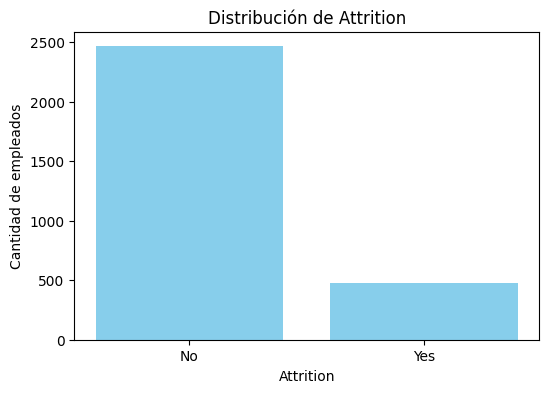

In [38]:
conteo_attrition = dataset["Attrition"].value_counts()
porcentaje_attrition = dataset["Attrition"].value_counts(normalize=True) * 100

print(pd.DataFrame({"Cantidad": conteo_attrition, "Porcentaje": porcentaje_attrition}))

plt.figure(figsize=(6, 4))
plt.bar(conteo_attrition.index, conteo_attrition.values, color='skyblue')
plt.xlabel("Attrition")
plt.ylabel("Cantidad de empleados")
plt.title("Distribución de Attrition")
plt.show()


Por último, se realiza una matriz de correlación para determinar cuales son las columnas (numericas) que tienen relación con la variable objetivo. Para ello se procede a utilizar Label encoder para las variables ordinales y one hot para las variables categoricas de baja cardinalidad.

           hrs  absences  JobInvolvement  PerformanceRating  \
0     6.612625        18               3                  0   
1     6.026815        18               2                  0   
2     6.966456        11               2                  0   
3     6.678438        12               3                  0   
4     6.235761        10               2                  0   
...        ...       ...             ...                ...   
2935  9.427815        12               2                  0   
2936  5.658448        17               2                  0   
2937  6.595091        10               2                  0   
2938  7.380757        16               1                  1   
2939  6.453039        19               2                  0   

      EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance  Age  \
0                           2                2                1   31   
1                           3                3                1   31   
2                          

# Evaluación

A continuación se divide el dataset original en train y test con una proporcion train (2/3) y test (1/3) manteniendo la proporcion de casos pertenecientes a la clase 'Si' en la variable objetivo.


In [39]:
from sklearn.preprocessing import LabelEncoder

dataset = dataset.dropna()
columnas_categoricas.remove("Attrition")
X = dataset.drop(columns=["Attrition"])
y = dataset["Attrition"]
y = y.map({"Yes": 1, "No": 0})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1/3, random_state=42, stratify=y)

train_distribution = y_train.value_counts(normalize=True) * 100
test_distribution = y_test.value_counts(normalize=True) * 100

print("\nDistribución en el conjunto de entrenamiento (Train):")
print(train_distribution)
print("\nDistribución en el conjunto de prueba (Test):")
print(test_distribution)



Distribución en el conjunto de entrenamiento (Train):
Attrition
0    83.786611
1    16.213389
Name: proportion, dtype: float64

Distribución en el conjunto de prueba (Test):
Attrition
0    83.786611
1    16.213389
Name: proportion, dtype: float64


# KNN

A continuacion definimos y entrenamos los diferentes modelos que usan KNN.
Para obtener los mejores hiperparámetros y el mejor escaler e imputer, se utiliza ColumnTransformer y pipelines para hacer el preprocesado y GridSearch para hacer la búsqueda de los mejores parametros basando su respuesa final en la precisión del modelo.

Dentro de esta busqueda de la mejor configuración de parámetros se encuentra el modelo por defecto de KNN (n_neighbors = 5, weights= 'uniform', metric= 'minkowski' y algorithm = 'auto').

El preprocesado consiste en [...]



In [40]:
from sklearn.model_selection import GridSearchCV
import time
# Search space
# rango de valores de hiperparametros que el metodo grid search CV va a probar
preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),  # Imputación para numéricas
        ("scaler", StandardScaler())  # Escalado de datos numéricos
    ]), columnas_numericas),

    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),  # Imputación para categóricas
        ("encoder", OneHotEncoder(handle_unknown="ignore"))  # OneHot para variables categóricas
    ]), columnas_categoricas),

    ("ord", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),  # Imputación para ordinales
        ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))  # OrdinalEncoder para categorías ordenadas
    ]), columnas_ordinales)
])

param_grid = {
    "preprocessor__num__imputer__strategy": ["mean", "median"],
    "preprocessor__num__scaler": [StandardScaler(), MinMaxScaler(), RobustScaler()],
    "classifier__n_neighbors": [3, 5, 7, 11],
    "classifier__weights": ["uniform", "distance"],
    "classifier__algorithm": ["auto", "ball_tree", "kd_tree"],
    "classifier__metric": ["euclidean", "manhattan", "minkowski"]
}

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", neighbors.KNeighborsClassifier())]
)

inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
search_cv = GridSearchCV(
    clf, param_grid,
    #n_iter=6,
    cv=inner,
    scoring="accuracy"
)

start_time = time.time()
search_cv.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
print(f"Tiempo de entrenamiento: {training_time:.4f} segundos")
print("Best params:")
print(search_cv.best_params_)

# y_pred_knn = knn_pipeline.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred_knn)
# print(accuracy)

Tiempo de entrenamiento: 156.2807 segundos
Best params:
{'classifier__algorithm': 'auto', 'classifier__metric': 'manhattan', 'classifier__n_neighbors': 11, 'classifier__weights': 'distance', 'preprocessor__num__imputer__strategy': 'mean', 'preprocessor__num__scaler': RobustScaler()}
